# Hotel booking

## Content:
### 1. EDA

The dataset contains data from two different hotels. One Resort hotel and one City hotel.

From the publication (https://www.sciencedirect.com/science/article/pii/S2352340918315191) we know that both hotels are located in Portugal.

The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".

Topics covered and questions to answer from the data:
- Where do the guests come from?
- How much do guests pay for a room per night?
- How does the price per night vary over the year?
- Which are the busiest months?
- How long do people stay at the hotels?
- How many bookings were canceled?
- Which month have the highest number of cancelations?

### 2. Predicting cancelations
Our main task is to predict guest cancelations, so the hotel can plan ahead and better its profits.
Our model will predict if a guest will actually come, and this can help the hotel to maybe offer more rooms than they have to make more money, and plan things like personel and food requirements better.

### 3. Evaluate Feature importance
Which features are most important to predict cancelations?  

In [61]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # Feature importance evaluation

# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

## First look at the data

In [62]:
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [63]:
# check for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

## Cleaning the data

In [64]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# We drop entries with no guests (rows that contains entreis with 0 adults, 0 children and 0 babies).
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [65]:
# How much data is left?
full_data_cln.shape

(119210, 32)

## 1. Data Visualization and EDA

In [66]:
# After cleaning, separate Resort and City hotel
# only bookings that were not canceled are included (to know the acutal visitor numbers).
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

### Where do the guests come from?

In [67]:
# number of guests by country
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index

# plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

### we learned that:
Most of the guests are from Portugal and other countries in Europe. 

### How much do guests pay for a room per night?  
Since no currency information is given we assume that all prices are in EUR. 


In [68]:
# Counting only adults and children as paying guests.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

In [69]:
print("""From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


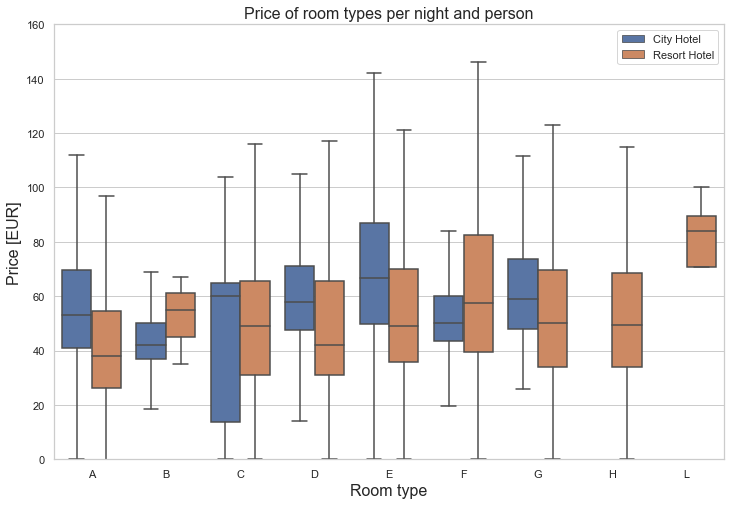

In [70]:
# normalize price per night (adr):
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# plot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

This figure shows the average price per room, depending on its type and the standard deviation.  

### Does the price per night vary over the year?  
We are using the average price per night and person, regardless of the room type and meal.  

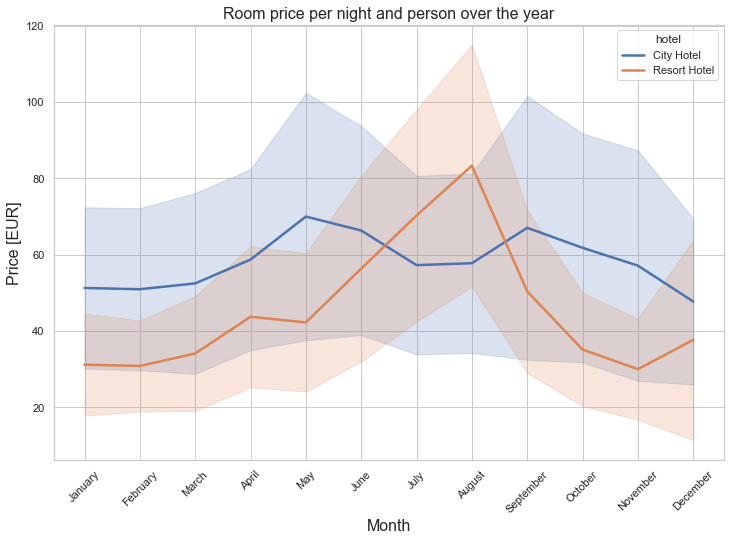

In [71]:
room_prices_mothly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# plot:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

### we learned that:
The prices in the Resort hotel are much higher during the summer (makes sense).   
The price of the city hotel varies less and is most expensive during spring and autumn. 

### Are some months busier than others?

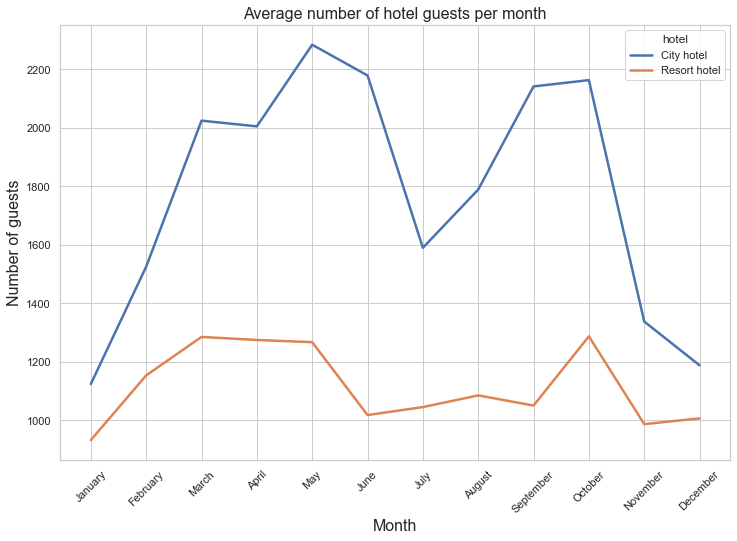

In [72]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

# plot:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

### we learned that:
The City hotel has more guests during spring and autumn, when the prices are also highest.   
In July and August there are less visitors, although prices are lower.  

Guest numbers for the Resort hotel go down slighty from June to September, which is also when the prices are highest.  
Both hotels have the fewest guests during the winter.

### How long do people stay at the hotels?

In [73]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

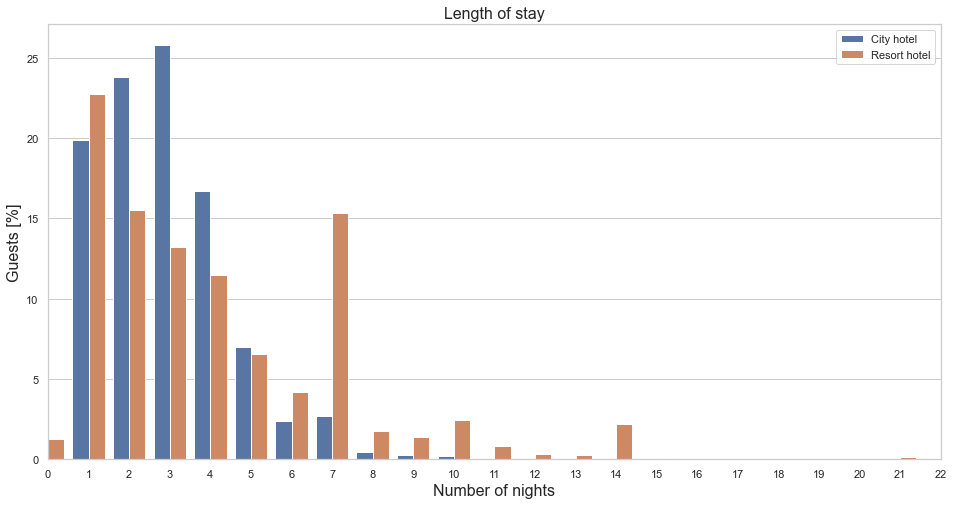

In [74]:
# plot
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [75]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


### we learned that:
For the city hotel there is a clear preference for 1-4 nights.  
For the resort hotel, 1-4 nights are also often booked, but 7 nights also stand out as being very popular. 

### Bookings by market segment

In [76]:
# total bookings per market segment (including canceled)
segments=full_data_cln["market_segment"].value_counts()

# plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

### How many bookings were canceled?

In [77]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


### Which month have the highest number of cancelations?

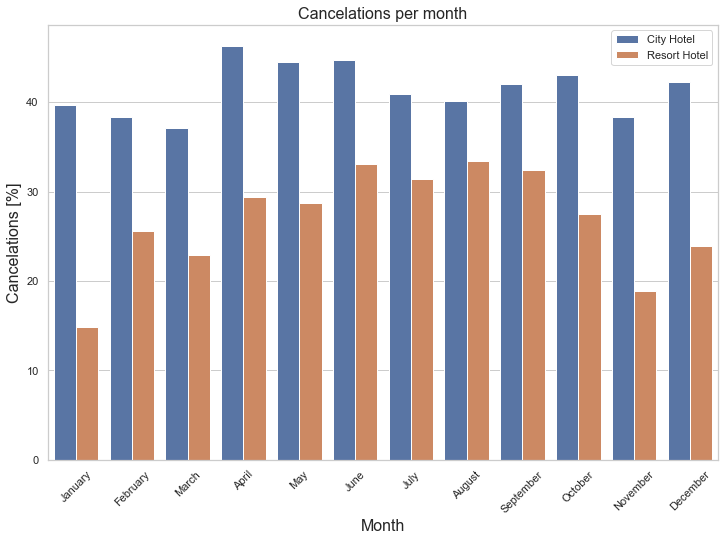

In [78]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

In [79]:
full_cancel_data.head()

,Hotel,Month,Bookings,Cancelations,cancel_percent
0,Resort Hotel,April,3609,1059,29.343308
1,Resort Hotel,August,4894,1637,33.449121
2,Resort Hotel,December,2645,631,23.856333
3,Resort Hotel,February,3102,794,25.596389
4,Resort Hotel,January,2191,325,14.833409


In [80]:
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### we learned that:
For the City hotel the relative number of cancelations is around 40 % throughout the year.  
For the Resort hotel it is highest in the summer and lowest during the winter. 

## 2. Predict cancelations  

### Which numerical features are most important? 

In [81]:
cancel_corr = full_data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

### we learned that:
lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.  
However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.  
We will also not include days_in_waiting_list and arrival_date_year.  
  
The most important feature to exclude is the "reservation_status":

In [82]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

### Comparing different base models:

In [83]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

# preprocess numerical features:
# for most num cols, except the dates, 0 is the most logical choice as fill value
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [84]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DT_model cross validation accuarcy score: 0.8246 +/- 0.0016 (std) min: 0.8221, max: 0.8263
RF_model cross validation accuarcy score: 0.8664 +/- 0.0012 (std) min: 0.8646, max: 0.8676
LR_model cross validation accuarcy score: 0.7937 +/- 0.0011 (std) min: 0.792, max: 0.7952
XGB_model cross validation accuarcy score: 0.8473 +/- 0.0011 (std) min: 0.8456, max: 0.8487


### we can see that:
The RandomForst model performs best.  

### After hyper-parameters tuning:

In [85]:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuarcy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.869


We can see that the improvement is minimal.

# 3. Evaluate Feature importance

In [86]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


### Lets look at the three most important features:  
- lead_time  
- deposit_type  
- adr

### lead_time:

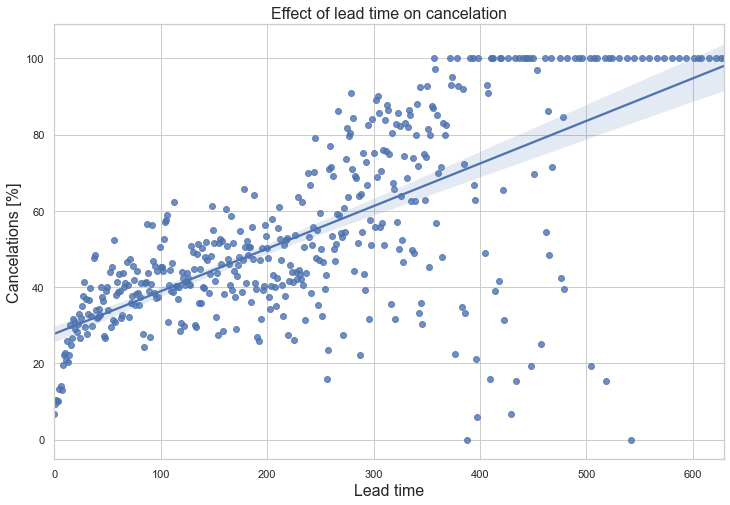

In [87]:
# group data for lead_time:
lead_cancel_data = full_data_cln.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

# plot
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

### We learn that:
Bookings made a few days before the arrival date are rarely canceled, whereas bookings made over one year in advance are canceled very often. 

### Deposit type:

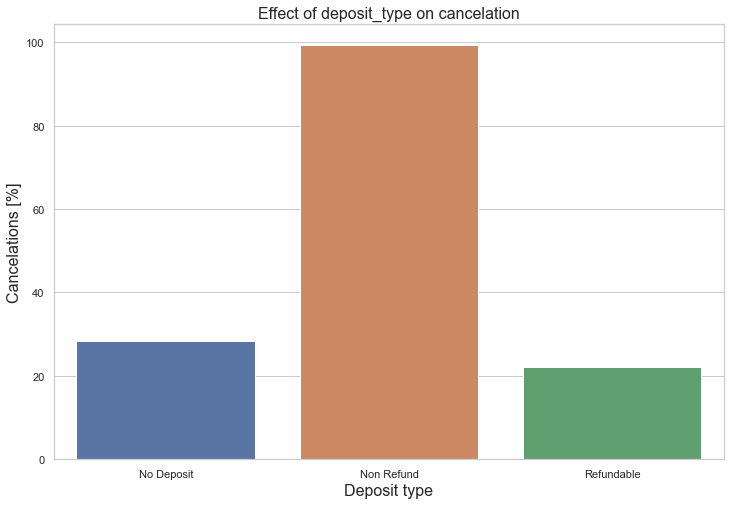

In [88]:
# group data for deposit_type:
deposit_cancel_data = full_data_cln.groupby("deposit_type")["is_canceled"].describe()

# plot
plt.figure(figsize=(12, 8))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

The deposit_type 'Non Refund' and the 'is_canceled'column are correlated in a counter-intuitive way.  
Over 99 % of people who paid the entire amount upfront canceled. This raises the question if there is something wrong with the data.  
Here is a table of all mean values of the data, grouped by deposit type:

In [89]:
deposit_mean_data = full_data_cln.groupby("deposit_type").mean()
deposit_mean_data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,adr_pp
deposit_type,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118604,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726,55.233383
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782,54.520286
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975,41.444239


Comparing the mean values for Non refund to No Deposit shows the following:
- Non Refund deposits are characterized by > 2x longer lead_time   
- is_repeated_guest is ~ 1/10th  
- previous_cancellations is 10x higher 
- previous_bookings_not_canceled is 1/15th  
- required_car_parking_spaces is almost zero  
- special requests are very rare 
  
Based on these findings it seems that especially people who have not previosly visited one of the hotels book, pay and cancel repeatedly... this is strange!
  
To adress this issue, we will make a model without this feature below.

### ADR:

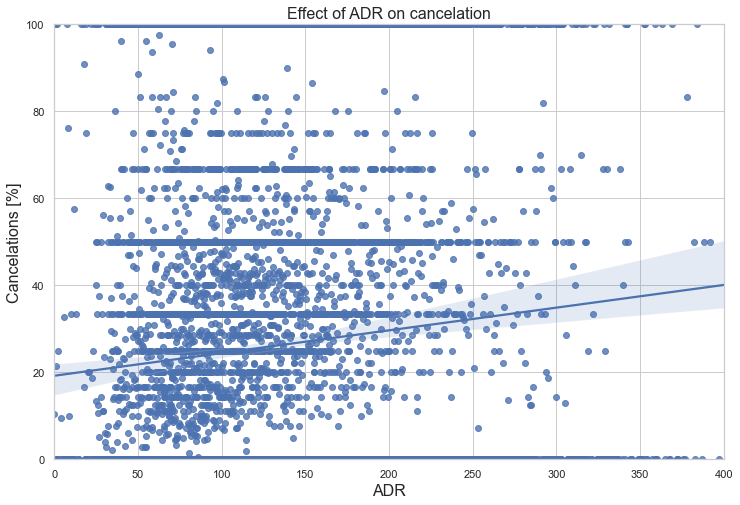

In [90]:
# group data for adr:
adr_cancel_data = full_data_cln.groupby("adr")["is_canceled"].describe()
#plot
plt.figure(figsize=(12, 8))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100)
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.show()

### RF model without deposit type:

In [91]:
cat_features_non_dep = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
X_non_dep = full_data.drop(["is_canceled"], axis=1)[features_non_dep]


# Bundle preprocessing for numerical and categorical features:
preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features_non_dep)])

# Define dataset:
X_non_dep = full_data.drop(["is_canceled"], axis=1)[features_non_dep]
# Define model
rf_model_non_dep = RandomForestClassifier(random_state=42) # basic model for this purpose

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                              ('model', rf_model_non_dep)])
cv_results = cross_val_score(model_pipe, 
                                 X_non_dep, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

RF model without deposit_type feature cross validation accuarcy score: 0.8653 +/- 0.0013 (std) min: 0.8631, max: 0.8663


In [92]:
# feature importance of original model:
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


In [93]:
# Check feature importance of new model:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X_non_dep,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features_non_dep))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df_non_dep = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)

In [94]:
# feat importance of new model:
feat_imp_df_non_dep.head(10)

,feature,weight,std
0,lead_time,0.175189,0.019580
1,adr,0.111566,0.008185
2,total_of_special_requests,0.078749,0.013435
3,arrival_date_day_of_month,0.076958,0.003056
4,arrival_date_week_number,0.060699,0.004069
5,agent,0.054862,0.009409
6,stays_in_week_nights,0.049275,0.004647
7,previous_cancellations,0.047592,0.016409
8,stays_in_weekend_nights,0.031298,0.002617
9,customer_type_Transient,0.028016,0.018087


The new accuracy score of 0.8653 is almost identical to the one obtained with the deposit_type included (0.8664),  
which placed significant wheight on this feature.  
The new model compensated this by placing increased weight on lead_time, adr, total_of_special_requests and others. 

### Looking at the total of special requests:

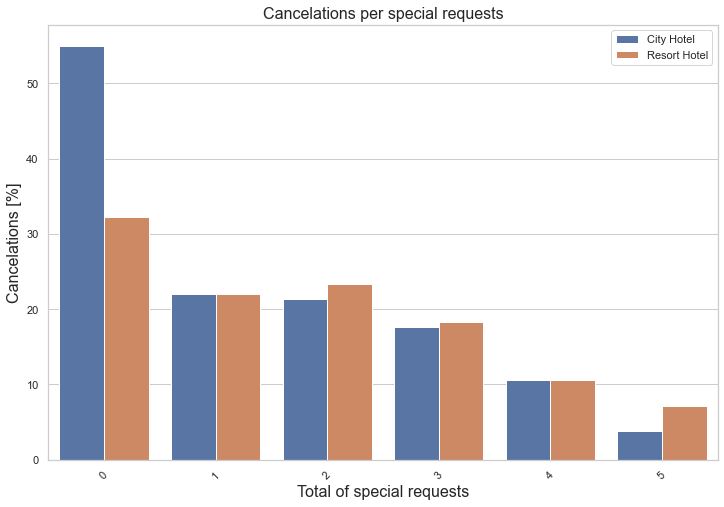

In [95]:
# Create a DateFrame with the relevant data:
res_book_per_req = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("total_of_special_requests")["hotel"].count()
res_cancel_per_req = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("total_of_special_requests")["is_canceled"].sum()

cty_book_per_req = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("total_of_special_requests")["hotel"].count()
cty_cancel_per_req = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("total_of_special_requests")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "req": list(res_book_per_req.index),
                                "Bookings": list(res_book_per_req.values),
                                "Cancelations": list(res_cancel_per_req.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "req": list(cty_book_per_req.index),
                                "Bookings": list(cty_book_per_req.values),
                                "Cancelations": list(cty_cancel_per_req.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100


# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "req", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per special requests", fontsize=16)
plt.xlabel("Total of special requests", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

### We learn that:
Most of the cancelations are correlated with the number of special requests.
The lower the requests - the higher the chance of cancelation.